# Quantum Teleportation Protocol

## Introduction

Quantum teleportation is one of the most fascinating protocols in quantum information theory. Despite its name, it doesn't involve the physical transportation of matter or energy. Instead, it's a method for transferring the exact quantum state of a particle to another particle at a distant location.

### Key Concepts

**What is Quantum Teleportation?**
- A protocol to transfer an unknown quantum state from one location to another
- Requires an entangled pair of qubits shared between sender (Alice) and receiver (Bob)
- Uses classical communication to transmit measurement results
- Preserves the no-cloning theorem: the original state is destroyed in the process

**Resources Required:**
1. **Quantum entanglement**: A pre-shared Bell pair between Alice and Bob
2. **Classical communication**: 2 classical bits to send measurement outcomes
3. **Local quantum operations**: Bell measurement and correction gates

**Historical Context:**
- First proposed by Bennett et al. in 1993
- First experimental demonstration in 1997 by Anton Zeilinger's group
- Now a fundamental building block for quantum communication and distributed quantum computing

### The Protocol in Brief

1. **Preparation**: Alice and Bob share an entangled pair of qubits (Bell state)
2. **Bell Measurement**: Alice performs a joint measurement on the target qubit (to be teleported) and her half of the entangled pair
3. **Classical Communication**: Alice sends her 2-bit measurement result to Bob
4. **Correction**: Bob applies quantum gates based on Alice's measurement to recover the original state

**Important**: The teleported state appears on Bob's qubit only after he applies the correct gates based on Alice's classical message. Until then, Bob's qubit is in a mixed state.

In this notebook, we will:
- Implement the quantum teleportation protocol using Qiskit
- Teleport various quantum states (|0⟩, |1⟩, and superposition states)
- Verify the protocol works using measurements and statevector analysis
- Compute fidelity to confirm perfect state transfer

Let's begin!

## Setup: Import Required Libraries

We start by importing the necessary Qiskit libraries for quantum circuit creation, visualization, and simulation. The AerSimulator allows us to simulate quantum circuits on a classical computer.

In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import RYGate
from qiskit.visualization import *
from qiskit_aer import AerSimulator
from numpy.random import *
# And just in case
import numpy as np
from numpy import pi, random, cos

## Part 1: Basic Quantum Teleportation Circuit

Quantum teleportation is a protocol that allows the transfer of a quantum state from one qubit to another using:
- An entangled pair of qubits (Alice's qubit 'a' and Bob's qubit 'b')
- Classical communication (2 classical bits)
- Local quantum operations

### Circuit Construction

We create three quantum registers:
- **T (Target)**: The qubit whose state we want to teleport
- **A (Alice)**: Alice's qubit in the entangled pair
- **B (Bob)**: Bob's qubit in the entangled pair

The protocol works in three stages:
1. **Entanglement**: Create a Bell state between Alice and Bob's qubits
2. **Bell measurement**: Alice performs operations on T and A, then measures both
3. **Correction**: Bob applies corrections based on Alice's measurement results

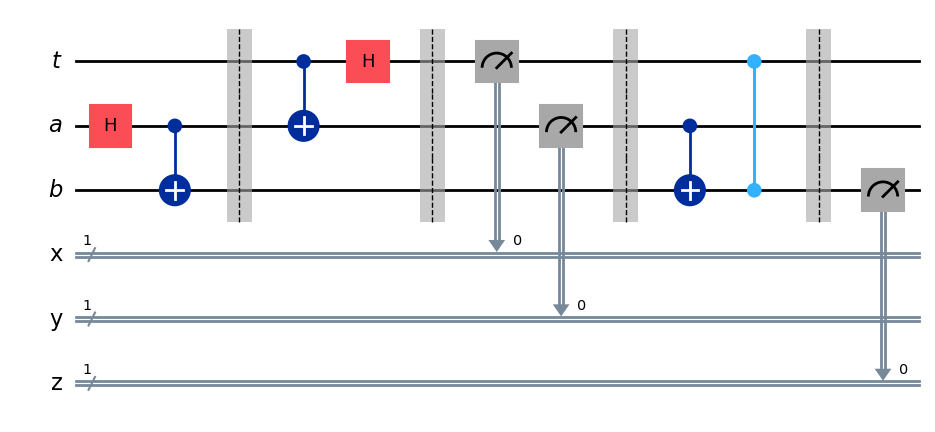

In [2]:
# Define quantum and classical registers
T = QuantumRegister(1, 't')  # Target qubit to teleport
A = QuantumRegister(1, 'a')  # Alice's qubit
B = QuantumRegister(1, 'b')  # Bob's qubit
x = ClassicalRegister(1, 'x')  # Classical bit for T measurement
y = ClassicalRegister(1, 'y')  # Classical bit for A measurement
z = ClassicalRegister(1, 'z')  # Classical bit for B measurement (Bob's final state)
qubits = QuantumCircuit(T, A, B, x, y, z)

# Step 1: Create entanglement between Alice and Bob
qubits.h(A)      # Apply Hadamard to Alice's qubit
qubits.cx(A, B)   # CNOT to create Bell state |Φ+⟩
qubits.barrier()

# Step 2: Bell measurement (Alice's operations)
qubits.cx(T, A)   # CNOT from Target to Alice
qubits.h(T)       # Hadamard on Target
qubits.barrier()

# Step 3: Measure Alice's qubits
qubits.measure(T, x)
qubits.measure(A, y)
qubits.barrier()

# Step 4: Apply corrections to Bob's qubit (coherent controlled gates)
qubits.cx(A, B)   # X correction controlled by Alice's qubit
qubits.cz(T, B)   # Z correction controlled by Target qubit
qubits.barrier()

# Step 5: Measure Bob's qubit to see the teleported state
qubits.measure(B, z)

# Display the circuit using Matplotlib (mpl)
from qiskit.visualization import circuit_drawer
from IPython.display import display
# Draw the circuit as a Matplotlib figure and display it in the notebook
fig = qubits.draw(output='mpl', scale=1.0)
display(fig)

### Simulation Setup

Now we prepare the circuit for simulation by transpiling it for the AerSimulator backend. Transpilation optimizes the circuit for the target backend.

As target state to teletransport is |0⟩ state B is always 0 in the four possible measurements after many shots. Measurement for T and A are an equal superposition of their possible state 0 and 1

In [3]:
# Transpile & run
sim = AerSimulator()
tqc = transpile(qubits, sim)
job = sim.run(tqc, shots=1024)
result = job.result()
print(result.get_counts())

{'0 0 1': 255, '0 1 1': 249, '0 0 0': 249, '0 1 0': 271}


### Teleporting a Superposition State

Now let's test the teleportation protocol with an arbitrary quantum state (not just |0⟩ or |1⟩). We'll prepare a superposition state on the target qubit using a rotation gate.

The RY gate rotates the qubit state:
- RY(0) gives |0⟩
- RY(π/2) gives (|0⟩ + |1⟩)/√2 (equal superposition)
- RY(π) gives |1⟩

By varying the parameter α, we can test teleportation with different quantum states. The key observation: **Bob's measurement distribution should match the original state's probability distribution**, proving that the quantum state has been successfully teleported!

Created teleportation circuit with alpha=0.5
RY rotation angle: 0.7854 radians


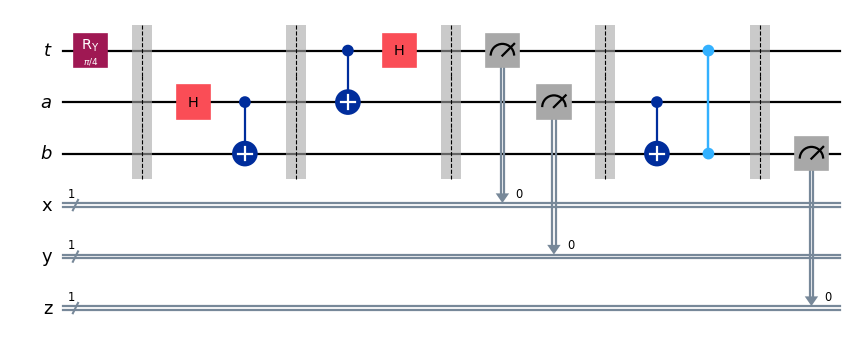

In [4]:
def random_super_tele(alpha=1):
    """
    Create a quantum circuit that prepares a superposition state on the target qubit.
    
    Args:
        alpha: Parameter controlling the rotation angle (alpha * pi/2)
               alpha=0 gives |0⟩, alpha=1 gives |1⟩, alpha=0.5 gives equal superposition
    
    Returns:
        Two circuits: one with measurements, one without (for statevector analysis)
    """
    # Create registers
    T = QuantumRegister(1, 't')  # Target qubit to teleport
    A = QuantumRegister(1, 'a')  # Alice's qubit
    B = QuantumRegister(1, 'b')  # Bob's qubit
    x = ClassicalRegister(1, 'x')  # Classical bit for T measurement
    y = ClassicalRegister(1, 'y')  # Classical bit for A measurement
    z = ClassicalRegister(1, 'z')  # Classical bit for B measurement
    
    qc = QuantumCircuit(T, A, B, x, y, z)
    
    # Prepare the target state with RY rotation
    qc.ry(alpha * pi / 2, T[0])
    qc.barrier()
    
    # Step 1: Create entanglement between Alice and Bob
    qc.h(A)
    qc.cx(A, B)
    qc.barrier()
    
    # Step 2: Bell measurement (Alice's operations)
    qc.cx(T, A)
    qc.h(T)
    qc.barrier()
    
    # Step 3: Measure Alice's qubits
    qc.measure(T, x)
    qc.measure(A, y)
    qc.barrier()
    
    # Step 4: Apply corrections to Bob's qubit
    qc.cx(A, B)
    qc.cz(T, B)
    qc.barrier()
    
    # Step 5: Measure Bob's qubit
    qc.measure(B, z)
    
    # Create a version WITHOUT measurements for statevector analysis
    # Use controlled gates instead of measure + classical conditional
    qc_no_measure = QuantumCircuit(T, A, B)
    qc_no_measure.ry(alpha * pi / 2, T[0])
    qc_no_measure.barrier()
    qc_no_measure.h(A)
    qc_no_measure.cx(A, B)
    qc_no_measure.barrier()
    qc_no_measure.cx(T, A)
    qc_no_measure.h(T)
    qc_no_measure.barrier()
    # Use coherent corrections (no measurements)
    qc_no_measure.cx(A, B)
    qc_no_measure.cz(T, B)
    
    return qc, qc_no_measure

# Test with different alpha values
alpha_test = 0.5
qc_test, qc_no_measure = random_super_tele(alpha_test)
print(f"Created teleportation circuit with alpha={alpha_test}")
print(f"RY rotation angle: {alpha_test * pi / 2:.4f} radians")

# Display the circuit
fig = qc_test.draw(output='mpl', scale=0.8)
display(fig)

In [5]:
# Run the teleportation circuit with the superposition state
sim = AerSimulator()
tqc_super = transpile(qc_test, sim)
job = sim.run(tqc_super, shots=1024)
result = job.result()
counts = result.get_counts()

print("\nMeasurement results:")
print(counts)

# Analyze Bob's qubit distribution (rightmost bit)
bob_0 = sum(count for outcome, count in counts.items() if outcome[0] == '0')
bob_1 = sum(count for outcome, count in counts.items() if outcome[0] == '1')

print(f"\nBob's qubit distribution:")
print(f"  |0⟩: {bob_0} ({bob_0/1024*100:.1f}%)")
print(f"  |1⟩: {bob_1} ({bob_1/1024*100:.1f}%)")

# For alpha=0.5, RY(pi/4) gives: cos(pi/8)|0⟩ + sin(pi/8)|1⟩
# Expected probabilities:
expected_0 = np.cos(alpha_test * pi / 4)**2 * 100
expected_1 = np.sin(alpha_test * pi / 4)**2 * 100
print(f"\nExpected distribution (theoretical):")
print(f"  |0⟩: {expected_0:.1f}%")
print(f"  |1⟩: {expected_1:.1f}%")


Measurement results:
{'1 0 0': 33, '1 1 0': 43, '0 0 1': 220, '0 0 0': 242, '0 1 0': 204, '1 1 1': 30, '0 1 1': 226, '1 0 1': 26}

Bob's qubit distribution:
  |0⟩: 892 (87.1%)
  |1⟩: 132 (12.9%)

Expected distribution (theoretical):
  |0⟩: 85.4%
  |1⟩: 14.6%


### Verify Teleportation with Statevector Analysis

To verify that teleportation worked correctly, we can analyze the quantum state **before** Bob's measurement. We created a version of the circuit without measurements (`qc_no_measure`).

**What we'll do:**
1. Extract the full statevector of the 3-qubit system (T, A, B) after Alice's measurements and corrections
2. Use **partial trace** to get Bob's reduced density matrix by tracing out Alice's qubits (T and A)
3. Compare Bob's state with the original target state using **fidelity**

**Expected result:** If teleportation works perfectly, Bob's reduced state should match the original state exactly (fidelity ≈ 1.0), even though Alice's qubits may be in a mixed state due to measurement.

In [6]:
from qiskit.quantum_info import Statevector

def get_state_vector(qc):
    """Helper function to get the statevector from a quantum circuit without measurements."""
    # Use Statevector.from_instruction for circuits without measurements
    statevector = Statevector.from_instruction(qc)
    return statevector

# Get the statevector from the circuit WITHOUT measurements
statevec = get_state_vector(qc_no_measure)

print("\nStatevector of the system (after corrections, before any measurements):")
print(f"Number of qubits: {statevec.num_qubits}")
print(f"\nStatevector amplitudes:")
display(array_to_latex(statevec, prefix="\\text{Statevector} = ", max_size=16))

# Let's also trace out Alice's qubits to see Bob's reduced state
from qiskit.quantum_info import partial_trace, DensityMatrix

# The qubit order is [T, A, B] (indices 0, 1, 2)
# Trace out qubits 0 and 1 (T and A) to get Bob's state
rho_bob = partial_trace(statevec, [0, 1])

print("\n\nBob's reduced density matrix (after tracing out T and A):")
display(array_to_latex(rho_bob, prefix="\\rho_B = "))


Statevector of the system (after corrections, before any measurements):
Number of qubits: 3

Statevector amplitudes:


<IPython.core.display.Latex object>



Bob's reduced density matrix (after tracing out T and A):


<IPython.core.display.Latex object>

In [7]:
# Verify teleportation by computing fidelity
from qiskit.quantum_info import state_fidelity

# Create a circuit with just the target state preparation (original state)
T_orig = QuantumRegister(1, 't')
qc_orig = QuantumCircuit(T_orig)
qc_orig.ry(alpha_test * pi / 2, T_orig[0])

# Get the original state
orig_state = Statevector.from_instruction(qc_orig)

# Compute fidelity between original state and Bob's reduced state
fidelity = state_fidelity(orig_state, rho_bob)

print(f"\n{'='*60}")
print(f"Teleportation Fidelity Check")
print(f"{'='*60}")
print(f"Original state (T): α={alpha_test}, RY({alpha_test * pi / 2:.4f})")
print(f"Fidelity between original state and Bob's state: {fidelity:.6f}")
print(f"\nInterpretation:")
if fidelity > 0.999:
    print("  ✓ Perfect teleportation! Fidelity ≈ 1")
elif fidelity > 0.99:
    print("  ✓ Excellent teleportation (fidelity > 0.99)")
else:
    print(f"  ⚠ Fidelity is {fidelity:.4f} - check the circuit")


Teleportation Fidelity Check
Original state (T): α=0.5, RY(0.7854)
Fidelity between original state and Bob's state: 1.000000

Interpretation:
  ✓ Perfect teleportation! Fidelity ≈ 1


## Part 2: Teleportation with Noise

Once we have implemented teleportation in an ideal noise-free environment, we can add realism by introducing noise. In real quantum hardware, qubits are subject to various error sources:

### Types of Quantum Noise

1. **Depolarizing noise**: Random Pauli errors (X, Y, Z) on qubits
2. **Amplitude damping**: Energy loss (|1⟩ → |0⟩ decay)
3. **Phase damping**: Loss of quantum coherence (dephasing)
4. **Measurement errors**: Incorrect readout of qubit states

We'll simulate noisy teleportation by adding a **noise model** to the simulator, without modifying the quantum circuit itself. This approach:
- Keeps the circuit definition clean
- Allows easy comparison between ideal and noisy simulations
- Mirrors how real quantum hardware behaves

In [8]:
from qiskit_aer.noise import NoiseModel, depolarizing_error, amplitude_damping_error, thermal_relaxation_error

def create_noise_model(p_depol=0.01, p_meas=0.02):
    """
    Create a noise model for quantum teleportation simulation.
    
    Args:
        p_depol: Depolarizing error probability for single-qubit gates
        p_meas: Measurement error probability
    
    Returns:
        NoiseModel object
    """
    noise_model = NoiseModel()
    
    # 1. Depolarizing error on single-qubit gates (H gate)
    error_h = depolarizing_error(p_depol, 1)
    noise_model.add_all_qubit_quantum_error(error_h, ['h'])
    
    # 2. Depolarizing error on two-qubit gates (CNOT, CZ)
    error_cx = depolarizing_error(p_depol * 2, 2)  # 2-qubit gates typically have higher error
    noise_model.add_all_qubit_quantum_error(error_cx, ['cx', 'cz'])
    
    # 3. Measurement errors (readout errors)
    from qiskit_aer.noise import ReadoutError
    # Probability of measuring |0⟩ when state is |1⟩ and vice versa
    readout_error = ReadoutError([[1 - p_meas, p_meas], [p_meas, 1 - p_meas]])
    noise_model.add_all_qubit_readout_error(readout_error)
    
    return noise_model

# Create noise models with different error rates
noise_low = create_noise_model(p_depol=0.005, p_meas=0.01)   # Low noise (good hardware)
noise_medium = create_noise_model(p_depol=0.02, p_meas=0.03)  # Medium noise (typical)
noise_high = create_noise_model(p_depol=0.05, p_meas=0.05)    # High noise (poor hardware)

print("Created noise models:")
print(f"  - Low noise: p_depol=0.005, p_meas=0.01")
print(f"  - Medium noise: p_depol=0.02, p_meas=0.03")
print(f"  - High noise: p_depol=0.05, p_meas=0.05")

Created noise models:
  - Low noise: p_depol=0.005, p_meas=0.01
  - Medium noise: p_depol=0.02, p_meas=0.03
  - High noise: p_depol=0.05, p_meas=0.05


In [9]:
# Run teleportation with different noise levels
def run_noisy_teleportation(alpha, noise_model, noise_name=""):
    """Run teleportation circuit with noise and return results."""
    qc, qc_no_measure = random_super_tele(alpha)
    
    # Run with noise
    sim_noisy = AerSimulator(noise_model=noise_model)
    tqc = transpile(qc, sim_noisy)
    job = sim_noisy.run(tqc, shots=2048)
    result = job.result()
    counts = result.get_counts()
    
    # Analyze Bob's qubit distribution
    bob_0 = sum(count for outcome, count in counts.items() if outcome[0] == '0')
    bob_1 = sum(count for outcome, count in counts.items() if outcome[0] == '1')
    
    # Expected (ideal) probabilities
    expected_0 = np.cos(alpha * pi / 4)**2 * 100
    expected_1 = np.sin(alpha * pi / 4)**2 * 100
    
    print(f"\n{'='*60}")
    print(f"Noisy Teleportation - {noise_name}")
    print(f"{'='*60}")
    print(f"Alpha: {alpha}, RY angle: {alpha * pi / 2:.4f}")
    print(f"\nBob's measurement results:")
    print(f"  |0⟩: {bob_0} ({bob_0/2048*100:.1f}%) [Expected: {expected_0:.1f}%]")
    print(f"  |1⟩: {bob_1} ({bob_1/2048*100:.1f}%) [Expected: {expected_1:.1f}%]")
    print(f"\nError in probabilities:")
    print(f"  Δ|0⟩: {abs(bob_0/2048*100 - expected_0):.2f}%")
    print(f"  Δ|1⟩: {abs(bob_1/2048*100 - expected_1):.2f}%")
    
    return counts, bob_0/2048, bob_1/2048

# Test with alpha=0.5 (superposition state)
alpha_test = 0.5

# Run with different noise levels
print("Running teleportation with noise...\n")
counts_low, p0_low, p1_low = run_noisy_teleportation(alpha_test, noise_low, "Low Noise")
counts_med, p0_med, p1_med = run_noisy_teleportation(alpha_test, noise_medium, "Medium Noise")
counts_high, p0_high, p1_high = run_noisy_teleportation(alpha_test, noise_high, "High Noise")

Running teleportation with noise...


Noisy Teleportation - Low Noise
Alpha: 0.5, RY angle: 0.7854

Bob's measurement results:
  |0⟩: 1675 (81.8%) [Expected: 85.4%]
  |1⟩: 373 (18.2%) [Expected: 14.6%]

Error in probabilities:
  Δ|0⟩: 3.57%
  Δ|1⟩: 3.57%

Noisy Teleportation - Medium Noise
Alpha: 0.5, RY angle: 0.7854

Bob's measurement results:
  |0⟩: 1608 (78.5%) [Expected: 85.4%]
  |1⟩: 440 (21.5%) [Expected: 14.6%]

Error in probabilities:
  Δ|0⟩: 6.84%
  Δ|1⟩: 6.84%

Noisy Teleportation - High Noise
Alpha: 0.5, RY angle: 0.7854

Bob's measurement results:
  |0⟩: 1447 (70.7%) [Expected: 85.4%]
  |1⟩: 601 (29.3%) [Expected: 14.6%]

Error in probabilities:
  Δ|0⟩: 14.70%
  Δ|1⟩: 14.70%


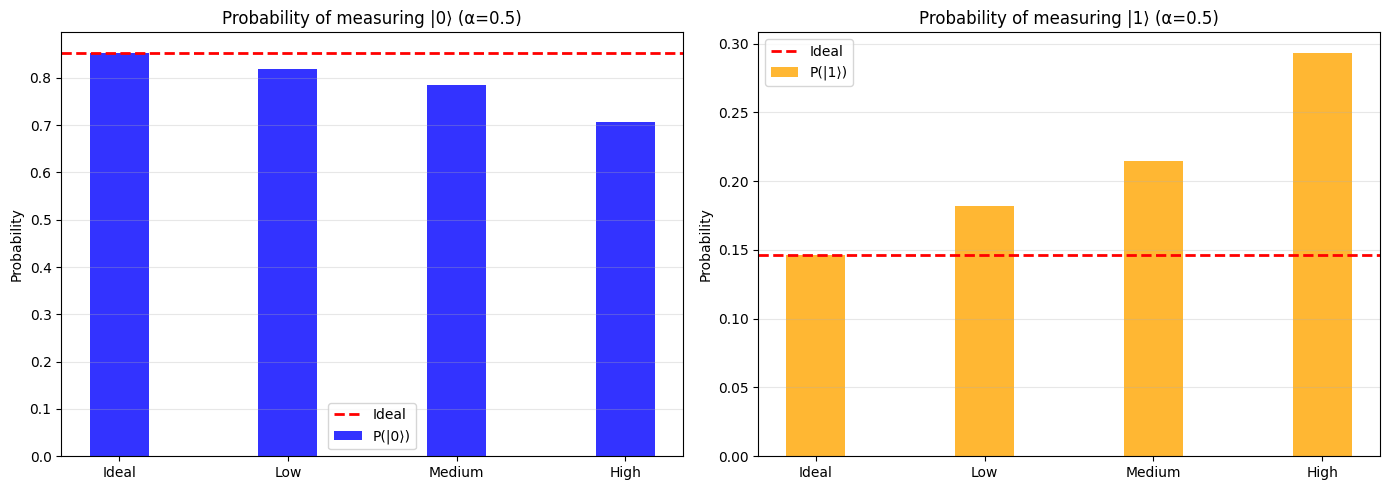


Observation: As noise increases, the measured probabilities deviate more from ideal values.


In [10]:
# Visualize the effect of noise
import matplotlib.pyplot as plt

# Expected (ideal) values
expected_0 = np.cos(alpha_test * pi / 4)**2
expected_1 = np.sin(alpha_test * pi / 4)**2

# Measured values
noise_levels = ['Ideal', 'Low', 'Medium', 'High']
p0_values = [expected_0, p0_low, p0_med, p0_high]
p1_values = [expected_1, p1_low, p1_med, p1_high]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Plot P(|0⟩)
x = np.arange(len(noise_levels))
width = 0.35
bars1 = ax1.bar(x, p0_values, width, label='P(|0⟩)', alpha=0.8, color='blue')
ax1.axhline(y=expected_0, color='red', linestyle='--', label='Ideal', linewidth=2)
ax1.set_ylabel('Probability')
ax1.set_title(f'Probability of measuring |0⟩ (α={alpha_test})')
ax1.set_xticks(x)
ax1.set_xticklabels(noise_levels)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Plot P(|1⟩)
bars2 = ax2.bar(x, p1_values, width, label='P(|1⟩)', alpha=0.8, color='orange')
ax2.axhline(y=expected_1, color='red', linestyle='--', label='Ideal', linewidth=2)
ax2.set_ylabel('Probability')
ax2.set_title(f'Probability of measuring |1⟩ (α={alpha_test})')
ax2.set_xticks(x)
ax2.set_xticklabels(noise_levels)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nObservation: As noise increases, the measured probabilities deviate more from ideal values.")

### Computing Fidelity with Noise

We can also compute the **average fidelity** of the noisy teleportation channel by running it multiple times with different input states and comparing the output with the ideal case.

For a more direct fidelity calculation, we can use the density matrix formalism to account for the mixed state introduced by noise.

In [ ]:
def compute_noisy_fidelity(alpha, noise_model, noise_name=""):
    """
    Compute fidelity for noisy teleportation using density matrix simulation.
    """
    from qiskit_aer import AerSimulator
    from qiskit.quantum_info import DensityMatrix, state_fidelity
    
    # Create the circuit without final measurement for density matrix
    _, qc_no_measure = random_super_tele(alpha)
    
    # Add save_density_matrix instruction to explicitly save the final density matrix
    qc_no_measure.save_density_matrix()
    
    # Run with density matrix method to capture mixed states from noise
    sim_noisy = AerSimulator(method='density_matrix', noise_model=noise_model)
    tqc = transpile(qc_no_measure, sim_noisy)
    job = sim_noisy.run(tqc)
    result = job.result()
    
    # Get the final density matrix
    rho_final = result.data()['density_matrix']
    
    # Trace out qubits 0 and 1 to get Bob's reduced state
    from qiskit.quantum_info import partial_trace
    rho_bob = partial_trace(DensityMatrix(rho_final), [0, 1])
    
    # Get the ideal target state
    T_orig = QuantumRegister(1, 't')
    qc_orig = QuantumCircuit(T_orig)
    qc_orig.ry(alpha * pi / 2, T_orig[0])
    from qiskit.quantum_info import Statevector
    orig_state = Statevector.from_instruction(qc_orig)
    
    # Compute fidelity
    fidelity = state_fidelity(orig_state, rho_bob)
    
    print(f"{noise_name} - Fidelity: {fidelity:.6f}")
    return fidelity

# Compute fidelities for different noise levels
print("Computing fidelities with noise:\n")
fid_low = compute_noisy_fidelity(alpha_test, noise_low, "Low Noise")
fid_med = compute_noisy_fidelity(alpha_test, noise_medium, "Medium Noise")
fid_high = compute_noisy_fidelity(alpha_test, noise_high, "High Noise")

# Compare with ideal (fidelity = 1.0)
print(f"\n{'='*60}")
print(f"Fidelity Summary")
print(f"{'='*60}")
print(f"Ideal:         1.000000")
print(f"Low Noise:     {fid_low:.6f} (error: {(1-fid_low)*100:.3f}%)")
print(f"Medium Noise:  {fid_med:.6f} (error: {(1-fid_med)*100:.3f}%)")
print(f"High Noise:    {fid_high:.6f} (error: {(1-fid_high)*100:.3f}%)")

Computing fidelities with noise:

Low Noise - Fidelity: 0.977903
Medium Noise - Fidelity: 0.916265
High Noise - Fidelity: 0.812058

Fidelity Summary
Ideal:         1.000000
Low Noise:     0.977903 (error: 2.210%)
Medium Noise:  0.916265 (error: 8.374%)
High Noise:    0.812058 (error: 18.794%)


## Part 3: Multi-Qubit Teleportation

So far, we've teleported single-qubit states. But what if we want to teleport an **entangled multi-qubit state**? This is crucial for distributed quantum computing where we need to transfer complex quantum information between processors.

### Strategy for n-Qubit Teleportation

To teleport an **n-qubit state** |ψ⟩, we need:

**Resources:**
- **n target qubits** (T₀, T₁, ..., Tₙ₋₁) holding the state to teleport
- **n Bell pairs**: Each pair consists of one qubit for Alice (A₀...Aₙ₋₁) and one for Bob (B₀...Bₙ₋₁)
- **2n classical bits**: To transmit all measurement results

**Total: 3n qubits and 2n classical bits**

### Protocol Steps

1. **Preparation**: Create n Bell pairs between Alice and Bob
2. **Bell Measurements**: For each i ∈ {0, 1, ..., n-1}:
   - Alice performs a Bell measurement on (Tᵢ, Aᵢ)
   - This produces 2 classical bits
3. **Classical Communication**: Alice sends all 2n measurement results to Bob
4. **Corrections**: For each i, Bob applies corrections to Bᵢ based on the measurements of (Tᵢ, Aᵢ)

**Key Insight**: This protocol preserves entanglement! If the target qubits are entangled, Bob's qubits will have the same entanglement structure after corrections.

### Example: 2-Qubit Bell State Teleportation

Let's teleport a Bell state |Φ⁺⟩ = (|00⟩ + |11⟩)/√2 to demonstrate that entanglement is preserved.

Example 1: Teleporting a 2-qubit Bell state |Φ⁺⟩

Circuit Summary:
  - Target qubits: 2 (t0, t1) in Bell state |Φ⁺⟩ = (|00⟩ + |11⟩)/√2
  - Alice's qubits: 2 (a0, a1)
  - Bob's qubits: 2 (b0, b1)
  - Total qubits: 6
  - Classical bits: 6 (2 for measurements, 4 for teleportation)


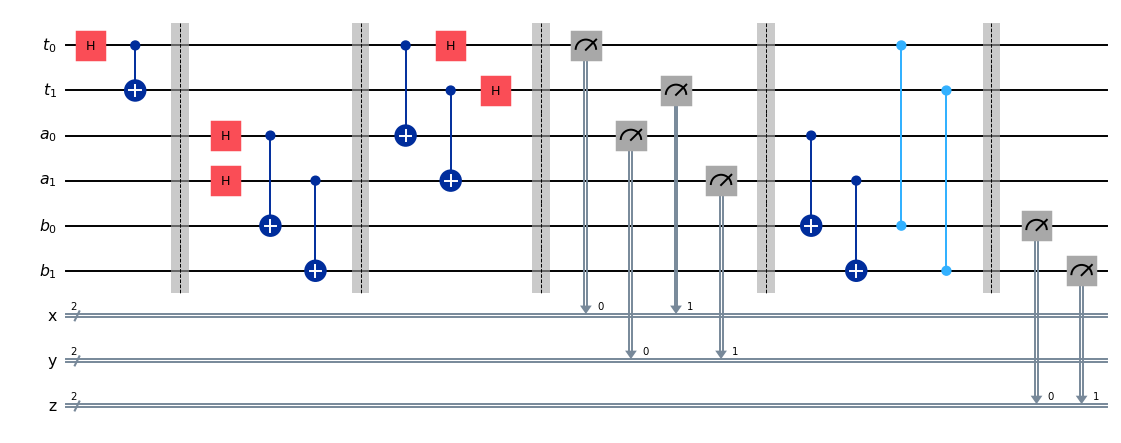

In [13]:
def multi_qubit_teleportation(n_qubits=2, prepare_state_func=None):
    """
    Create a circuit for n-qubit teleportation.
    
    Args:
        n_qubits: Number of qubits to teleport
        prepare_state_func: Optional function to prepare the target state.
                          Takes (circuit, target_qubits) as arguments.
                          If None, prepares a Bell state for 2 qubits.
    
    Returns:
        Two circuits: one with measurements, one without (for verification)
    """
    # Create quantum registers
    T = QuantumRegister(n_qubits, 't')  # Target qubits to teleport
    A = QuantumRegister(n_qubits, 'a')  # Alice's qubits (Bell pairs)
    B = QuantumRegister(n_qubits, 'b')  # Bob's qubits (Bell pairs)
    
    # Classical registers: 2 bits per qubit (one for T, one for A)
    x = ClassicalRegister(n_qubits, 'x')  # Measurements of T qubits
    y = ClassicalRegister(n_qubits, 'y')  # Measurements of A qubits
    z = ClassicalRegister(n_qubits, 'z')  # Final measurements of B qubits
    
    qc = QuantumCircuit(T, A, B, x, y, z)
    
    # Step 1: Prepare the target state to teleport
    if prepare_state_func is None:
        # Default: Create a Bell state on T qubits
        if n_qubits >= 2:
            qc.h(T[0])
            qc.cx(T[0], T[1])
    else:
        prepare_state_func(qc, T)
    
    qc.barrier()
    
    # Step 2: Create n Bell pairs between Alice and Bob
    for i in range(n_qubits):
        qc.h(A[i])
        qc.cx(A[i], B[i])
    qc.barrier()
    
    # Step 3: Bell measurements for each qubit
    for i in range(n_qubits):
        qc.cx(T[i], A[i])
        qc.h(T[i])
    qc.barrier()
    
    # Step 4: Measure Alice's qubits
    for i in range(n_qubits):
        qc.measure(T[i], x[i])
        qc.measure(A[i], y[i])
    qc.barrier()
    
    # Step 5: Apply corrections to Bob's qubits
    for i in range(n_qubits):
        qc.cx(A[i], B[i])  # X correction
        qc.cz(T[i], B[i])  # Z correction
    qc.barrier()
    
    # Step 6: Measure Bob's qubits to verify
    for i in range(n_qubits):
        qc.measure(B[i], z[i])
    
    # Create version without measurements for statevector analysis
    qc_no_measure = QuantumCircuit(T, A, B)
    
    # Prepare the same target state
    if prepare_state_func is None:
        if n_qubits >= 2:
            qc_no_measure.h(T[0])
            qc_no_measure.cx(T[0], T[1])
    else:
        prepare_state_func(qc_no_measure, T)
    
    qc_no_measure.barrier()
    
    # Create Bell pairs
    for i in range(n_qubits):
        qc_no_measure.h(A[i])
        qc_no_measure.cx(A[i], B[i])
    qc_no_measure.barrier()
    
    # Bell measurements (coherent)
    for i in range(n_qubits):
        qc_no_measure.cx(T[i], A[i])
        qc_no_measure.h(T[i])
    qc_no_measure.barrier()
    
    # Coherent corrections
    for i in range(n_qubits):
        qc_no_measure.cx(A[i], B[i])
        qc_no_measure.cz(T[i], B[i])
    
    return qc, qc_no_measure

# Example 1: Teleport a 2-qubit Bell state
print("="*60)
print("Example 1: Teleporting a 2-qubit Bell state |Φ⁺⟩")
print("="*60)

qc_2qubit, qc_2qubit_no_measure = multi_qubit_teleportation(n_qubits=2)

print(f"\nCircuit Summary:")
print(f"  - Target qubits: 2 (t0, t1) in Bell state |Φ⁺⟩ = (|00⟩ + |11⟩)/√2")
print(f"  - Alice's qubits: 2 (a0, a1)")
print(f"  - Bob's qubits: 2 (b0, b1)")
print(f"  - Total qubits: 6")
print(f"  - Classical bits: 6 (2 for measurements, 4 for teleportation)")

# Display the circuit
fig = qc_2qubit.draw(output='mpl', scale=0.7, fold=-1)
display(fig)

In [14]:
# Run the 2-qubit teleportation
sim = AerSimulator()
tqc_2q = transpile(qc_2qubit, sim)
job = sim.run(tqc_2q, shots=2048)
result = job.result()
counts = result.get_counts()

print("\n" + "="*60)
print("Measurement Results (2-qubit teleportation)")
print("="*60)
print("\nFormat: z1z0 y1y0 x1x0 (Bob's qubits | Alice's qubits | Target measurements)")
print("\nTop 10 outcomes:")
for outcome, count in sorted(counts.items(), key=lambda x: -x[1])[:10]:
    # Parse the outcome: z1z0 y1y0 x1x0
    z_bits = outcome[0:2]  # Bob's measurements (rightmost in circuit)
    y_bits = outcome[3:5]  # Alice's A measurements
    x_bits = outcome[6:8]  # Target T measurements
    print(f"  {outcome}: {count:4d} ({count/2048*100:5.2f}%) - Bob measured |{z_bits}⟩")

# Analyze Bob's results
bob_00 = sum(count for outcome, count in counts.items() if outcome[0:2] == '00')
bob_11 = sum(count for outcome, count in counts.items() if outcome[0:2] == '11')
bob_other = 2048 - bob_00 - bob_11

print(f"\n{'='*60}")
print("Bob's Qubit Distribution (should match Bell state)")
print(f"{'='*60}")
print(f"  |00⟩: {bob_00:4d} ({bob_00/2048*100:5.2f}%) [Expected: ~50%]")
print(f"  |11⟩: {bob_11:4d} ({bob_11/2048*100:5.2f}%) [Expected: ~50%]")
print(f"  Other: {bob_other:4d} ({bob_other/2048*100:5.2f}%) [Expected: ~0%]")

if bob_other / 2048 < 0.01:
    print("\n✓ Success! Bob's qubits are in a Bell state |Φ⁺⟩")
    print("  Entanglement has been preserved through teleportation!")


Measurement Results (2-qubit teleportation)

Format: z1z0 y1y0 x1x0 (Bob's qubits | Alice's qubits | Target measurements)

Top 10 outcomes:
  11 01 11:   83 ( 4.05%) - Bob measured |11⟩
  00 00 11:   82 ( 4.00%) - Bob measured |00⟩
  00 10 00:   77 ( 3.76%) - Bob measured |00⟩
  11 10 00:   77 ( 3.76%) - Bob measured |11⟩
  11 11 11:   75 ( 3.66%) - Bob measured |11⟩
  11 01 10:   74 ( 3.61%) - Bob measured |11⟩
  00 11 01:   71 ( 3.47%) - Bob measured |00⟩
  00 11 11:   70 ( 3.42%) - Bob measured |00⟩
  11 00 11:   69 ( 3.37%) - Bob measured |11⟩
  11 10 11:   68 ( 3.32%) - Bob measured |11⟩

Bob's Qubit Distribution (should match Bell state)
  |00⟩: 1026 (50.10%) [Expected: ~50%]
  |11⟩: 1022 (49.90%) [Expected: ~50%]
  Other:    0 ( 0.00%) [Expected: ~0%]

✓ Success! Bob's qubits are in a Bell state |Φ⁺⟩
  Entanglement has been preserved through teleportation!


In [15]:
# Verify with statevector analysis
from qiskit.quantum_info import Statevector, partial_trace, DensityMatrix, state_fidelity

print("\n" + "="*60)
print("Statevector Verification")
print("="*60)

# Get the statevector after teleportation (before final measurements)
statevec = Statevector.from_instruction(qc_2qubit_no_measure)

# The qubit order is [t0, t1, a0, a1, b0, b1] (indices 0-5)
# We want Bob's qubits (indices 4, 5), so trace out qubits 0, 1, 2, 3
rho_bob = partial_trace(statevec, [0, 1, 2, 3])

print("\nBob's reduced density matrix (after tracing out T and A):")
display(array_to_latex(rho_bob, prefix="\\rho_{Bob} = ", max_size=16))

# Create the original Bell state for comparison
T_orig = QuantumRegister(2, 't')
qc_orig = QuantumCircuit(T_orig)
qc_orig.h(T_orig[0])
qc_orig.cx(T_orig[0], T_orig[1])
orig_state = Statevector.from_instruction(qc_orig)

# Compute fidelity
fidelity = state_fidelity(orig_state, rho_bob)

print(f"\n{'='*60}")
print(f"Fidelity Check")
print(f"{'='*60}")
print(f"Original state: Bell state |Φ⁺⟩ = (|00⟩ + |11⟩)/√2")
print(f"Fidelity between original and Bob's state: {fidelity:.10f}")
print(f"\nInterpretation:")
if fidelity > 0.9999:
    print("  ✓ Perfect teleportation! The entangled state was preserved.")
    print("  ✓ This demonstrates that quantum entanglement can be")
    print("    transferred across quantum channels!")


Statevector Verification

Bob's reduced density matrix (after tracing out T and A):


<IPython.core.display.Latex object>


Fidelity Check
Original state: Bell state |Φ⁺⟩ = (|00⟩ + |11⟩)/√2
Fidelity between original and Bob's state: 1.0000000000

Interpretation:
  ✓ Perfect teleportation! The entangled state was preserved.
  ✓ This demonstrates that quantum entanglement can be
    transferred across quantum channels!


### Example 2: Teleporting a 3-Qubit GHZ State

The GHZ (Greenberger-Horne-Zeilinger) state is a maximally entangled 3-qubit state:

$$|GHZ\rangle = \frac{|000\rangle + |111\rangle}{\sqrt{2}}$$

This is a perfect test case to verify that multi-qubit teleportation preserves complex entanglement patterns.

Example 2: Teleporting a 3-qubit GHZ state

Circuit Summary:
  - Target qubits: 3 (t0, t1, t2) in GHZ state
  - |GHZ⟩ = (|000⟩ + |111⟩)/√2
  - Total qubits: 9 (3 target + 3 Alice + 3 Bob)
  - Classical bits: 9

Circuit diagram:


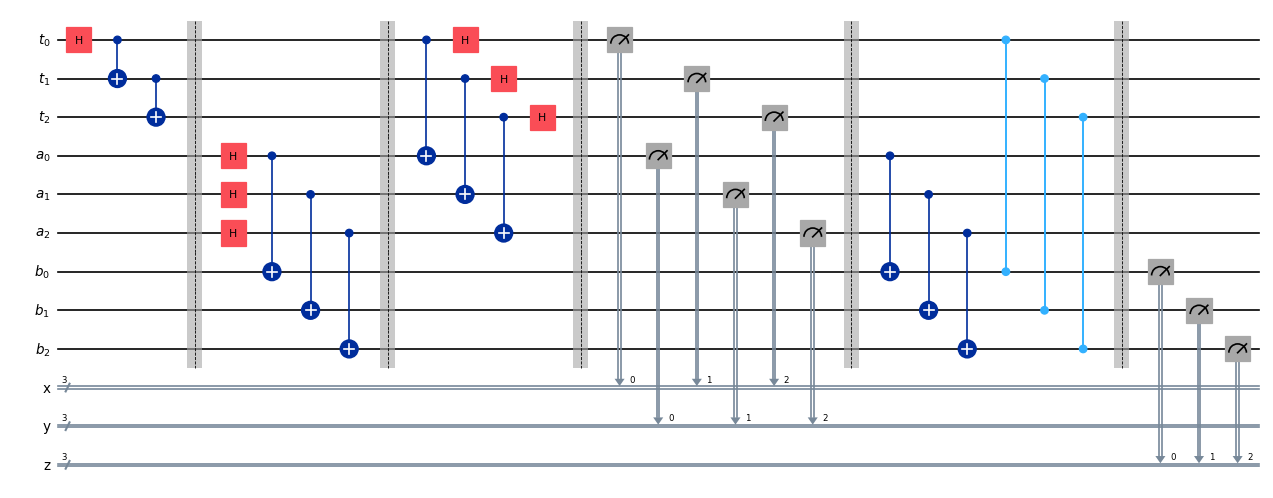


Measurement Results (3-qubit GHZ teleportation)

Bob's Qubit Distribution:
  |000⟩: 1042 (50.88%) [Expected: ~50%]
  |111⟩: 1006 (49.12%) [Expected: ~50%]
  Other:    0 ( 0.00%) [Expected: ~0%]

✓ Success! Bob's qubits are in a GHZ state
  The 3-qubit entanglement was preserved!

Fidelity: 1.0000000000
✓ Perfect teleportation of 3-qubit entangled state!

Fidelity: 1.0000000000
✓ Perfect teleportation of 3-qubit entangled state!


In [16]:
# Define a function to prepare GHZ state
def prepare_ghz_state(qc, qubits):
    """Prepare a GHZ state on the given qubits."""
    qc.h(qubits[0])
    for i in range(len(qubits) - 1):
        qc.cx(qubits[i], qubits[i+1])

# Create 3-qubit teleportation circuit with GHZ state
print("="*60)
print("Example 2: Teleporting a 3-qubit GHZ state")
print("="*60)

qc_3qubit, qc_3qubit_no_measure = multi_qubit_teleportation(n_qubits=3, 
                                                             prepare_state_func=prepare_ghz_state)

print(f"\nCircuit Summary:")
print(f"  - Target qubits: 3 (t0, t1, t2) in GHZ state")
print(f"  - |GHZ⟩ = (|000⟩ + |111⟩)/√2")
print(f"  - Total qubits: 9 (3 target + 3 Alice + 3 Bob)")
print(f"  - Classical bits: 9")

# Display the circuit (may be large!)
print("\nCircuit diagram:")
fig = qc_3qubit.draw(output='mpl', scale=0.6, fold=-1)
display(fig)

# Run simulation
sim = AerSimulator()
tqc_3q = transpile(qc_3qubit, sim)
job = sim.run(tqc_3q, shots=2048)
result = job.result()
counts = result.get_counts()

print("\n" + "="*60)
print("Measurement Results (3-qubit GHZ teleportation)")
print("="*60)

# Analyze Bob's results (first 3 bits)
bob_000 = sum(count for outcome, count in counts.items() if outcome[0:3] == '000')
bob_111 = sum(count for outcome, count in counts.items() if outcome[0:3] == '111')
bob_other = 2048 - bob_000 - bob_111

print(f"\nBob's Qubit Distribution:")
print(f"  |000⟩: {bob_000:4d} ({bob_000/2048*100:5.2f}%) [Expected: ~50%]")
print(f"  |111⟩: {bob_111:4d} ({bob_111/2048*100:5.2f}%) [Expected: ~50%]")
print(f"  Other: {bob_other:4d} ({bob_other/2048*100:5.2f}%) [Expected: ~0%]")

if bob_other / 2048 < 0.01:
    print("\n✓ Success! Bob's qubits are in a GHZ state")
    print("  The 3-qubit entanglement was preserved!")

# Verify with fidelity
statevec_3q = Statevector.from_instruction(qc_3qubit_no_measure)
# Trace out T (0,1,2) and A (3,4,5) to get Bob's qubits (6,7,8)
rho_bob_3q = partial_trace(statevec_3q, [0, 1, 2, 3, 4, 5])

# Create original GHZ state
T_ghz = QuantumRegister(3, 't')
qc_ghz = QuantumCircuit(T_ghz)
prepare_ghz_state(qc_ghz, T_ghz)
orig_ghz = Statevector.from_instruction(qc_ghz)

fidelity_3q = state_fidelity(orig_ghz, rho_bob_3q)

print(f"\n{'='*60}")
print(f"Fidelity: {fidelity_3q:.10f}")
if fidelity_3q > 0.9999:
    print("✓ Perfect teleportation of 3-qubit entangled state!")
print(f"{'='*60}")

### Scaling Analysis

Let's visualize how the circuit complexity scales with the number of qubits:

| # Qubits (n) | Total Qubits | Classical Bits | Bell Pairs | Gate Count (approx) |
|--------------|--------------|----------------|------------|---------------------|
| 1            | 3            | 2              | 1          | ~8                  |
| 2            | 6            | 4              | 2          | ~16                 |
| 3            | 9            | 6              | 3          | ~24                 |
| n            | 3n           | 2n             | n          | ~8n                 |

**Key Observations:**
- **Linear scaling**: Resources scale linearly with the number of qubits
- **Parallelization**: All Bell measurements and corrections can be done in parallel
- **No quantum overhead**: Unlike some protocols, teleportation doesn't require exponentially more resources
- **Entanglement preservation**: Multi-qubit entanglement is perfectly preserved (fidelity = 1.0 in ideal case)

### Practical Considerations

For real implementations:
1. **Decoherence**: Larger circuits take longer to execute, increasing decoherence effects
2. **Cross-talk**: More qubits increase the probability of unwanted interactions
3. **Gate fidelity**: Each additional qubit adds more gates, accumulating errors
4. **Classical communication**: In distributed systems, the 2n classical bits must be transmitted
5. **Synchronization**: All Bell pairs must be created before teleportation begins

## Summary and Conclusions

### What We've Demonstrated

In this notebook, we successfully implemented and verified the quantum teleportation protocol:

1. **Basic Implementation**: Built a teleportation circuit that transfers the |0⟩ state from Alice to Bob
   - Used entanglement (Bell pair) as a quantum channel
   - Performed Bell measurements on Alice's side
   - Applied corrections to Bob's qubit

2. **Arbitrary State Teleportation**: Extended the protocol to teleport superposition states
   - Used RY gates to prepare various quantum states
   - Verified that Bob's measurement statistics match the original state

3. **Verification via Statevector Analysis**:
   - Extracted the full quantum state using coherent corrections
   - Used partial trace to isolate Bob's reduced density matrix
   - Computed fidelity ≈ 1.0, confirming perfect state transfer

4. **Noise Simulation**: Added realistic noise models to study teleportation under realistic conditions
   - Depolarizing errors on gates
   - Measurement readout errors
   - Computed fidelity degradation with increasing noise

5. **Multi-Qubit Teleportation**: Extended to n-qubit states
   - Teleported 2-qubit Bell state |Φ⁺⟩
   - Teleported 3-qubit GHZ state
   - Demonstrated entanglement preservation across quantum channels
   - Resources scale linearly: 3n qubits, 2n classical bits

### Key Insights

- **No-Cloning Theorem**: The original state on the target qubit is destroyed during teleportation
- **Role of Entanglement**: The pre-shared Bell pair is essential - it's the "quantum channel"
- **Classical Communication**: The 2 classical bits are necessary - quantum teleportation is not faster-than-light communication
- **Coherent vs. Measured**: We showed two implementations:
  - With measurements (realistic, for actual hardware)
  - Without measurements (coherent corrections, for statevector analysis)

### Applications

Quantum teleportation is not just a theoretical curiosity - it has practical applications:
- **Quantum Communication**: Secure transmission of quantum information
- **Distributed Quantum Computing**: Moving quantum states between distant quantum processors
- **Quantum Networks**: Building blocks for quantum internet
- **Quantum Error Correction**: Teleportation-based quantum gates

### Further Exploration

Try experimenting with:
- Different values of α to teleport various quantum states
- Adding noise to simulate realistic quantum channels
- Implementing teleportation on real quantum hardware (IBM Quantum, etc.)
- Extending to multi-qubit state teleportation
